# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

##  1.Introduction: Business Problem <a name="introduction"></a>

__Problem background__:

I have been living in Malmö, Sweden for the last 15 years. I am not a Swede myself. I came here as an expat due to  work reasons.
My company offered me a choice of staying in an  apartment, and I could choose from several apartments that were available within budget.

I remember my first choice, it was the one that had the nicest furniture. Only later when I started to get to know the neighbourhood did I realize that there weren’t any great restaurants around or bars, so for me it wasn’t ideal, I was single and didn’t do any cooking at home. So after 6 months I moved to another apartment that was closer to the office and luckily with plenty of restaurants and bars around, so I regret a bit the hastily choice I did at first.

I realize that the problem that I faced then is still a valid one today, for people that came today to Malmö

according to Wikipedia:
”In 2011, people from 174 countries were represented in Malmö, speaking 150 languages”
https://en.wikipedia.org/wiki/Malm%C3%B6#Demographics




__Business problem__:

For a person that comes to Sweden being single or having a family the problem we are trying to solve is which borough should they move to, given their preferences on certain categories like restaurants vs proximity to playgrounds or shops.

This study will also aim to help choosing the borough given the relative price of the square meter of an apartment versus the percentage of venues of a given category in Malmö. This is a way to help establish the “value for money” of a given borough on a given category. An area may have a high percentage of shops for example but if the price of the square meter is very high, maybe worth instead to go to a borough with lesser shops but a more affordable price per square meter




__Stakeholders interested__:

A single person maybe interested in living close to restaurants and bars to socialize, where as a a person with a family may prefer proximity to grocery shops, playgrounds. 

This study well help both types of stakeholders finding a borough that best suits their preferences

## 2.Data <a name="data"></a>

####  Following data will be used:


| Description | Purpose |
|:----|----:|
| wikipedia page for Malmö  | this data will enable us to identify the list of boroughs |
| wikipedia pages for Malmö bouroughs | this data will enable us to identify the list of neighoorhoods |
| geopy api for geo coordinates for a neighboorhood | this data will enable us to determine the neighoorhood location |
| foursquare api for venues |this will enable us to the details on venues, name, categories |
| maklarstatistik.se data |this webpage has the average apartment prices sold in malmö by borough |
| folium api |this data will enable to display maps of Malmö |

    




We will start by scraping the data for boroughs from wikipedia, then get the neighboorhoods also from wikipedia , then scrape the apartment prices and finaly the venue details from the foursquare API.

After scraping the data we will also do some data cleaning and preparation: check for missing values, duplicates


Lets start by importing some needed libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import seaborn as sns

pd.set_option('mode.chained_assignment', None) #switch off warnigs for copy with slicing

import matplotlib.pyplot as plt
%matplotlib inline  


### 2.1 Data Scraping boroughs 

for scraping I am using selenium, I find it easier to work with than beautifulsoup. If you don't want to install it I placed the scraped data in github, so just load the pickle files to follow along. To install selenium just uncomment the line below

In [2]:
#!pip install selenium

In [3]:
from selenium import webdriver
driver=webdriver.Chrome()

we will start by scraping the __city districts__ for Malmö from wikipedia, city districts are equivalent to __boroughs__. We will get the boroughs as they were defined up to 2013, after the structure was changed, but there is less data with the new structure

In [4]:

my_url="https://en.wikipedia.org/wiki/Malm%C3%B6_Municipality"

driver.get(my_url)

html = driver.page_source.encode('utf-8')
res=pd.read_html(html)

boroughs_df=res[3]







In [5]:
boroughs_df.head(3)

,City district,Population[9],Area(hectare)[10],Density(people/km²)
0,Centrum,47171,1757,2685
1,Fosie,43889,1243,3531
2,Limhamn-Bunkeflo,42646,5147,829


In [6]:

if not "city" in str(boroughs_df.columns[0]).lower():
    boroughs_df.columns=boroughs_df.iloc[0,:]
    boroughs_df=boroughs_df.iloc[1:,:]
    boroughs_df.reset_index(inplace=True,drop=True)
    

In [7]:
boroughs_df.head(3)

,City district,Population[9],Area(hectare)[10],Density(people/km²)
0,Centrum,47171,1757,2685
1,Fosie,43889,1243,3531
2,Limhamn-Bunkeflo,42646,5147,829


In [8]:
boroughs_df["links"]=""
elems = driver.find_elements_by_xpath("//a[@href]")
links=[]
start=False
count=0
for elem in elems:
    val=elem.get_attribute("href")
    if (start==False) and ("centrum" in val.lower()):
        start=True
    if (start==True) & (count<10):
        boroughs_df["links"].iloc[count]=val
        count+=1
        
boroughs_df["Population[9]"]=boroughs_df["Population[9]"].astype(int) #convert to int to allow calculations

This table contains the boroughs as of 1 January 2013 and the population at the time.
This table also has links to the detail of the borough , each borough contains links to the neighboorhoods.After 2013 there is a new structure for the Malmö boroughs, but I am not using this since in wikipedia there is more info pertaining to the old structure

In [9]:
boroughs_df # 10 boroughs

,City district,Population[9],Area(hectare)[10],Density(people/km²),links
0,Centrum,47171,1757,2685,"https://en.wikipedia.org/wiki/Centrum,_Malm%C3%B6"
1,Fosie,43889,1243,3531,https://en.wikipedia.org/wiki/Fosie
2,Limhamn-Bunkeflo,42646,5147,829,https://en.wikipedia.org/wiki/Limhamn-Bunkeflo
3,Södra Innerstaden,34671,302,11480,https://en.wikipedia.org/wiki/S%C3%B6dra_Inner...
4,Västra Innerstaden,33191,465,7138,https://en.wikipedia.org/wiki/V%C3%A4stra_Inne...
5,Hyllie,32998,901,3662,https://en.wikipedia.org/wiki/Hyllie
6,Rosengård,23563,332,7097,https://en.wikipedia.org/wiki/Roseng%C3%A5rd
7,Husie,20769,2948,705,https://en.wikipedia.org/wiki/Husie
8,Kirseberg,14959,640,2337,https://en.wikipedia.org/wiki/Kirseberg
9,Oxie,12453,2306,540,https://en.wikipedia.org/wiki/Oxie


In [10]:
# save file to pickle you can find it on github
#boroughs_df.to_pickle("./boroughs_df.pkl") 

### 2.3 Data Scraping neighboorhoods

Now lets scrape the __neighboorhoods__ for each borough

In [11]:
#create a function
def scrape_neigh_by_borough(borough_link,borough_name):
    driver.get(borough_link)

    elems = driver.find_elements_by_xpath("//a[@href]")



    vals=[]
    relevant=False
    for elem in elems:
        
        title=elem.get_attribute("title")
        link=elem.get_attribute("href")
        text=elem.get_attribute("text")
        if "neighbourhoods" in title.lower():
            relevant=True
            continue
        if "enlarge" in title.lower():
            continue
        if (relevant==True) & ("edit" in title.lower()):
            relevant=False
            continue
        if (relevant==True) & ("mosque" in title.lower()):
            relevant=False
            continue
        if (len(link)>0) & (len(title)>1) &(relevant==True) :
            vals.append((title,link))
    vals_df=pd.DataFrame(vals,columns=["neigh_name","neigh_link"])
    vals_df["borough"]=borough_name
    return vals_df


#loops through all the boroughs and create a df with the neighboorhoods
for lin in range(len(boroughs_df)):
    borough_link=boroughs_df["links"].iloc[lin]
    borough_name=boroughs_df["City district"].iloc[lin]
    if lin==0:
        neigh_df=scrape_neigh_by_borough(borough_link,borough_name)
    else:
        neigh_df=pd.concat([neigh_df,scrape_neigh_by_borough(borough_link,borough_name)],axis=0)
        

neigh_df.reset_index(drop=True,inplace=True)

now we have a dataframe with the neightboords and their wiki links and the borough:

In [14]:
neigh_df.head(10)

,neigh_name,neigh_link,borough
0,Davidshall,https://en.wikipedia.org/wiki/Davidshall,Centrum
1,Ellstorp,https://en.wikipedia.org/wiki/Ellstorp,Centrum
2,"Frihamnen, Malmö","https://en.wikipedia.org/wiki/Frihamnen,_Malm%...",Centrum
3,"Gamla staden, Malmö","https://en.wikipedia.org/wiki/Gamla_staden,_Ma...",Centrum
4,Inre hamnen,https://en.wikipedia.org/wiki/Inre_hamnen,Centrum
5,Katrinelund,https://en.wikipedia.org/wiki/Katrinelund,Centrum
6,"Lugnet, Malmö","https://en.wikipedia.org/wiki/Lugnet,_Malm%C3%B6",Centrum
7,Malmöhus,https://en.wikipedia.org/wiki/Malm%C3%B6hus,Centrum
8,Mellersta hamnen,https://en.wikipedia.org/wiki/Mellersta_hamnen,Centrum
9,"Norra hamnen, Malmö","https://en.wikipedia.org/wiki/Norra_hamnen,_Ma...",Centrum


In [15]:
neigh_df.shape #should be 137 rows, 3 colums , 137 neighboorhoods

(137, 3)

Lets also get the __geo-coordinates__ for each of the neighboorhoods, by using geopy address lookup


In [16]:
#we create a geopy address that includes the neighoorhood name and the city
def create_address(val):
    if "malmö" in val.lower():
        if "," in val:
            return val
        else:
            return val+" ,Malmö"
            
    else:
        return val+" ,Malmö"

neigh_df["address"]=neigh_df["neigh_name"].apply(create_address)

neigh_df["geopy_address"]=neigh_df["address"]
#lets do some cleanup and replace some values with ones that geopy can recognize
neigh_df["geopy_address"].loc[neigh_df["geopy_address"]=="Universitetssjukhuset MAS ,Malmö"]="Allmänna sjukhuset, Malmö"
neigh_df["geopy_address"].loc[neigh_df["geopy_address"]=="Sorgenfri industriområde ,Malmö"]="Norra Sorgenfri, Malmö"
neigh_df["geopy_address"].loc[neigh_df["geopy_address"]=="Teatern (område) ,Malmö"]="Teatern, Malmö"
neigh_df["geopy_address"].loc[neigh_df["geopy_address"]=="Limhamns kalkbrott ,Malmö"]="Kalkbrottet ,Malmö"





In [17]:
#now we loop through all the addresses to get the lat and longitude
neigh_df["geopy_lat"]=0
neigh_df["geopy_long"]=0


In [18]:
from time import sleep

the geopy interface sometimes times out so in case the api fails it sleeps 2 seconds

In [19]:

lin=0
while lin<(len(neigh_df)):
    if lin%5==0:
        print (lin) #prints every 5 items to check speed of progress
    if neigh_df["geopy_lat"].iloc[lin]>0:
        lin+=1
        continue
    address=neigh_df["geopy_address"].iloc[lin]
    geolocator = Nominatim(user_agent="malmo_explorer")
    try:
        location = geolocator.geocode(address)
       
        sleep(0.5)
        try:
            neigh_df["geopy_lat"].iloc[lin]= location.latitude
            neigh_df["geopy_long"].iloc[lin] = location.longitude
            if  location.latitude>0:
                lin+=1
                if lin>=137:
                    break
        except:
            neigh_df["geopy_lat"].iloc[lin]=np.nan
            neigh_df["geopy_long"].iloc[lin]=np.nan
    except Exception as e :
        print (e, "line",lin)
        sleep(2)
        
print ("done")        
    
        


0
Service timed out line 4
5
Service timed out line 6
Service timed out line 9
Service timed out line 9
10
Service timed out line 11
Service timed out line 13
15
20
Service timed out line 20
20
Service timed out line 22
25
30
35
Service timed out line 36
Service timed out line 36
40
Service timed out line 40
40
Service timed out line 41
Service timed out line 43
45
Service timed out line 46
50
Service timed out line 53
55
60
Service timed out line 62
Service timed out line 63
65
Service timed out line 69
70
75
Service timed out line 79
80
85
90
95
100
105
110
Service timed out line 112
Service timed out line 113
115
120
125
130
Service timed out line 133
135
done


lets check for geo-codes with zero values:

In [29]:
neigh_df[neigh_df["geopy_lat"]==0].count() #there shoudn't be any

neigh_name       0
neigh_link       0
borough          0
address          0
geopy_address    0
geopy_lat        0
geopy_long       0
dtype: int64

In [20]:
neigh_df.head(5)

,neigh_name,neigh_link,borough,address,geopy_address,geopy_lat,geopy_long
0,Davidshall,https://en.wikipedia.org/wiki/Davidshall,Centrum,"Davidshall ,Malmö","Davidshall ,Malmö",55.598823,12.998539
1,Ellstorp,https://en.wikipedia.org/wiki/Ellstorp,Centrum,"Ellstorp ,Malmö","Ellstorp ,Malmö",55.604265,13.032631
2,"Frihamnen, Malmö","https://en.wikipedia.org/wiki/Frihamnen,_Malm%...",Centrum,"Frihamnen, Malmö","Frihamnen, Malmö",55.615554,13.010210
3,"Gamla staden, Malmö","https://en.wikipedia.org/wiki/Gamla_staden,_Ma...",Centrum,"Gamla staden, Malmö","Gamla staden, Malmö",55.604449,13.002700
4,Inre hamnen,https://en.wikipedia.org/wiki/Inre_hamnen,Centrum,"Inre hamnen ,Malmö","Inre hamnen ,Malmö",55.612736,13.010973


### 2.4 Data cleaning neighboorhoods dataframe

lets check if there are any missing values

In [21]:
neigh_df.isnull().sum() #should be zero

neigh_name       0
neigh_link       0
borough          0
address          0
geopy_address    0
geopy_lat        0
geopy_long       0
dtype: int64

Lets check if the same neighoorhood is assigned to multiple boroughs:
Västra Sorgenfri neighboorhood is showing in multiple boroughs

In [22]:
neigh_df["borough"].groupby(neigh_df["neigh_name"]).count().sort_values(ascending=False).head(5)

neigh_name
Västra Sorgenfri            2
Östra kyrkogården, Malmö    1
Håkanstorp                  1
Jägersro villastad          1
Jägersro                    1
Name: borough, dtype: int64

In [23]:
neigh_df.reset_index(inplace=True,drop=True)

in the new borough structure it belongs to "Södra Innerstaden" so we will drop_it from centrum

In [24]:
neigh_df["borough"][neigh_df["neigh_name"]=="Västra Sorgenfri"]

18              Centrum
66    Södra Innerstaden
Name: borough, dtype: object

In [25]:
pos=neigh_df.index[(neigh_df["neigh_name"]=="Västra Sorgenfri") & (neigh_df["borough"]=="Centrum") ]
neigh_df.drop(pos,axis=0,inplace=True)


In [26]:
neigh_df.reset_index(inplace=True,drop=True)

In [27]:
neigh_df["borough"][neigh_df["neigh_name"]=="Västra Sorgenfri"]

65    Södra Innerstaden
Name: borough, dtype: object

In [28]:
neigh_df.shape  #shape should be 136 rows 

(136, 7)

In [30]:
#neigh_df.to_pickle("./neigh_df.pkl") # save to picke..you can find the file in github

### 2.5 Data scraping Venue details

Now we can use the foursquare api to get the list of venues in each neighboorhood.

In [31]:
CLIENT_ID = 'UFMUDJ1XWZG5W3MN1A1LQVCTJYESAUAT05KKXAPC5JUXB4NA' # your Foursquare ID
CLIENT_SECRET = '0XY1DGS45ZVS20LG0U02NSS4QEVKONY1P4JUZ1ZHPLTXXNGA' # your Foursquare Secret


This method will create a dataframe with the __detail of the venues__ and the info on the neighboord and borough

In [32]:
def create_venues_df(lat,long,neigh_name,borough_name):
    neighborhood_latitude=lat
    neighborhood_longitude=long
    
    LIMIT = 200 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    VERSION="20191007"
     # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()
    
    try:
        total_venues=results['response']['totalResults']
    except:
        return np.nan,np.nan
        
    
    
    venues = results['response']['groups'][0]['items']
    
    
    nearby_venues = json_normalize(venues) # flatten JSON
    
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
            
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
        
    # filter columns
    try:
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        redu_nearby_venues =nearby_venues.loc[:, filtered_columns]
    except:
        return np.nan,np.nan
    
    redu_nearby_venues["link"]="" 
    for lin in range(len(nearby_venues)):
        redu_nearby_venues["link"].iloc[lin]=nearby_venues["venue.categories"].iloc[lin][0]["icon"]["prefix"]
        
    # filter the category for each row
    redu_nearby_venues['venue.categories'] = redu_nearby_venues.apply(get_category_type, axis=1)
    
    # clean columns
    redu_nearby_venues.columns = [col.split(".")[-1] for col in redu_nearby_venues.columns]
    
    #foursquare in the link field provides a main category and a sub-category, this will be useful for us
    redu_nearby_venues["categ_1"]=redu_nearby_venues["link"].apply(lambda x: x.split("/")[-2])
    redu_nearby_venues["categ_2"]=redu_nearby_venues["link"].apply(lambda x: x.split("/")[-1].replace("_",""))
    redu_nearby_venues["neigh_name"]=neigh_name
    redu_nearby_venues["borough"]=borough_name
    
    return total_venues,redu_nearby_venues



lets loop through all the neighboorhoods and get the detailed df with venues and concatenate that into a df

In [35]:
neigh_df["total_venues"]=0

print ("started running...")
for lin in range(len(neigh_df)):
    neigh_name=neigh_df["neigh_name"].iloc[lin]
    borough_name=neigh_df["borough"].iloc[lin]
    cur_total_venues=neigh_df["total_venues"].iloc[lin]
    if cur_total_venues>0:
        continue
    lat=neigh_df["geopy_lat"].iloc[lin]
    long=neigh_df["geopy_long"].iloc[lin]
    total_venues,redu_nearby_venues=create_venues_df(lat,long,neigh_name,borough_name)    
    neigh_df["total_venues"].iloc[lin]=total_venues
    #in case of no venues we try a couple of times
    if (total_venues==0) | (pd.Series(total_venues)[-1:].isnull()[0]):
        num_tries=0
        while (num_tries<4) &   ( (total_venues==0) | (pd.Series(total_venues)[-1:].isnull()[0])) :
            total_venues,redu_nearby_venues=create_venues_df(lat,long,neigh_name,borough_name)    
            neigh_df["total_venues"].iloc[lin]=total_venues
            sleep(1)
            print ("got no data trying again ",lin)
            num_tries+=1
            
    if lin==0:
        details_venues_df=redu_nearby_venues.copy()
    else:
        if total_venues>0:
            details_venues_df=pd.concat([details_venues_df,redu_nearby_venues],axis=0)
        
print ("done")

started running...
got no data trying again  8
got no data trying again  8
got no data trying again  8
got no data trying again  8
got no data trying again  47
got no data trying again  47
got no data trying again  47
got no data trying again  47
got no data trying again  53
got no data trying again  53
got no data trying again  53
got no data trying again  53
got no data trying again  107
got no data trying again  107
got no data trying again  107
got no data trying again  107
got no data trying again  111
got no data trying again  111
got no data trying again  111
got no data trying again  111
got no data trying again  130
got no data trying again  130
got no data trying again  130
got no data trying again  130
got no data trying again  132
got no data trying again  132
got no data trying again  132
got no data trying again  132
done


####  please note: the number of venues retrieved is variable: people add entries to Foursquare all the time so the number of venues will be different in the future

In [37]:
details_venues_df.shape # here  I got 1425 rows

(1425, 9)

In [38]:
details_venues_df.head(10)

,name,categories,lat,lng,link,categ_1,categ_2,neigh_name,borough
0,Riket,Scandinavian Restaurant,55.598697,12.997290,https://ss3.4sqi.net/img/categories_v2/food/sc...,food,scandinavian,Davidshall,Centrum
1,ustwo Nordics,Design Studio,55.599086,13.000199,https://ss3.4sqi.net/img/categories_v2/shops/d...,shops,design,Davidshall,Centrum
2,Science Fiction Bokhandeln,Bookstore,55.598314,13.001172,https://ss3.4sqi.net/img/categories_v2/shops/b...,shops,bookstore,Davidshall,Centrum
3,AB Småland,Café,55.597621,13.001020,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum
4,Lotta Love Superfoodbar,Café,55.597517,13.000299,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum
5,Bullen (Två Krögare),Scandinavian Restaurant,55.599956,13.001333,https://ss3.4sqi.net/img/categories_v2/food/sc...,food,scandinavian,Davidshall,Centrum
6,Escama,Spanish Restaurant,55.599887,12.996117,https://ss3.4sqi.net/img/categories_v2/food/sp...,food,spanish,Davidshall,Centrum
7,Bôru,Asian Restaurant,55.599126,13.000419,https://ss3.4sqi.net/img/categories_v2/food/as...,food,asian,Davidshall,Centrum
8,La Bonne Vie,French Restaurant,55.598948,12.998106,https://ss3.4sqi.net/img/categories_v2/food/fr...,food,french,Davidshall,Centrum
9,Konditori Hollandia,Café,55.600161,13.001107,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum


now the neighboorhood dataframe (neigh_df) is updated the the total number of venues for each neighboorhood __(total_venues)__

In [39]:
neigh_df.head(5)

,neigh_name,neigh_link,borough,address,geopy_address,geopy_lat,geopy_long,total_venues
0,Davidshall,https://en.wikipedia.org/wiki/Davidshall,Centrum,"Davidshall ,Malmö","Davidshall ,Malmö",55.598823,12.998539,54.0
1,Ellstorp,https://en.wikipedia.org/wiki/Ellstorp,Centrum,"Ellstorp ,Malmö","Ellstorp ,Malmö",55.604265,13.032631,5.0
2,"Frihamnen, Malmö","https://en.wikipedia.org/wiki/Frihamnen,_Malm%...",Centrum,"Frihamnen, Malmö","Frihamnen, Malmö",55.615554,13.010210,3.0
3,"Gamla staden, Malmö","https://en.wikipedia.org/wiki/Gamla_staden,_Ma...",Centrum,"Gamla staden, Malmö","Gamla staden, Malmö",55.604449,13.002700,75.0
4,Inre hamnen,https://en.wikipedia.org/wiki/Inre_hamnen,Centrum,"Inre hamnen ,Malmö","Inre hamnen ,Malmö",55.612736,13.010973,5.0


### 2.6 Data cleaning Venue details

In [40]:
neigh_df.isnull().sum() # 7 neighboordhoods have no venues

neigh_name       0
neigh_link       0
borough          0
address          0
geopy_address    0
geopy_lat        0
geopy_long       0
total_venues     7
dtype: int64

There are neigboorhoods for which there are no venues tagged in the foursquare api. These are mostly residential neighboorhoods that are not too hip and trendy, I guess most users on foursquare focus on restaurants, bars, hotels.

In [41]:
neigh_df[["neigh_name","borough"]][neigh_df["total_venues"].isnull()]

,neigh_name,borough
8,Mellersta hamnen,Centrum
47,Naffentorp,Limhamn-Bunkeflo
53,Tygelsjö vång,Limhamn-Bunkeflo
107,Fortuna Hemgården,Husie
111,Kvarnby,Husie
130,"Kungshög, Malmö",Oxie
132,Lockarp,Oxie


And now we have a __dataframe with the venue details__ linked to the neighboorhood and borough

In [42]:
details_venues_df.head(5)

,name,categories,lat,lng,link,categ_1,categ_2,neigh_name,borough
0,Riket,Scandinavian Restaurant,55.598697,12.997290,https://ss3.4sqi.net/img/categories_v2/food/sc...,food,scandinavian,Davidshall,Centrum
1,ustwo Nordics,Design Studio,55.599086,13.000199,https://ss3.4sqi.net/img/categories_v2/shops/d...,shops,design,Davidshall,Centrum
2,Science Fiction Bokhandeln,Bookstore,55.598314,13.001172,https://ss3.4sqi.net/img/categories_v2/shops/b...,shops,bookstore,Davidshall,Centrum
3,AB Småland,Café,55.597621,13.001020,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum
4,Lotta Love Superfoodbar,Café,55.597517,13.000299,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum


since we are scraping the api with a radious of 500 metres and it is quite possible that some venues overlap. Lets create a field with name + lat+long and see if we have duplicates

In [43]:
details_venues_df["comb_name_lat_long"]=details_venues_df[["name","lat","lng"]].apply(lambda x: str(x["name"])+"_"+str(x["lat"])+"_"+str(x["lng"]),axis=1)


Possibly overlaps/duplicates:

In [45]:
details_venues_df["comb_name_lat_long"].shape[0]-len(details_venues_df["comb_name_lat_long"].unique())

557

lets check a few cases

In [46]:
pos_dup=details_venues_df["name"].groupby(details_venues_df["comb_name_lat_long"]).count().sort_values(ascending=False).head(4)
pos_dup

comb_name_lat_long
Lotta Love Superfoodbar_55.59751704677513_13.000298985578043       5
Rosengård Centrum_55.58586454746462_13.045630722224347             5
Leve_55.59678745868187_12.999759311098433                          5
ICA Supermarket Rönneholm_55.595269155462596_12.981513852077592    5
Name: name, dtype: int64

In [47]:
details_venues_df[["name","neigh_name","borough"]][details_venues_df["name"]==str(pos_dup.index[0]).split("_")[0]]

,name,neigh_name,borough
4,Lotta Love Superfoodbar,Davidshall,Centrum
14,Lotta Love Superfoodbar,"Lugnet, Malmö",Centrum
20,Lotta Love Superfoodbar,Rådmansvången,Centrum
18,Lotta Love Superfoodbar,"Hästhagen, Malmö",Västra Innerstaden
11,Lotta Love Superfoodbar,Teatern (område),Västra Innerstaden


In order to have a venue belonging to one neighoorhood and borough in exclusivity we could determine which neighoorhood/borough is closest to the venue. To keep things simple in this exercise I will take the first neighoorhood/borough in the dataframe and remove the others as duplicates

In [48]:
details_venues_nodup=details_venues_df.sort_values("comb_name_lat_long").drop_duplicates("comb_name_lat_long",keep="first")

In [50]:
details_venues_nodup.shape # unique venues by name and geo-coordinates, #venues now down to 868

(868, 10)

Sanity check:

In [51]:
details_venues_nodup["name"].groupby(details_venues_nodup["comb_name_lat_long"]).count().sort_values(ascending=False).head(4)

comb_name_lat_long
Özens allfrukt_55.58113451881973_13.019258762040769    1
HappyCandy_55.55339_12.99581                           1
Hotel Duxiana_55.606962531221065_12.997366425814416    1
Hot Yoga Malmö_55.607249762169054_13.00642088443348    1
Name: name, dtype: int64

In [52]:
details_venues_nodup.head(3)

,name,categories,lat,lng,link,categ_1,categ_2,neigh_name,borough,comb_name_lat_long
2,&child,Fountain,55.570288,12.976737,https://ss3.4sqi.net/img/categories_v2/parks_o...,parks_outdoors,plaza,Kroksbäcksparken,Hyllie,&child_55.570288_12.976737
24,400 grader,Italian Restaurant,55.593553,13.006270,https://ss3.4sqi.net/img/categories_v2/food/it...,food,italian,Möllevången,Södra Innerstaden,400 grader_55.59355349987836_13.006270170359914
4,7Eleven,Automotive Shop,55.574993,12.989868,https://ss3.4sqi.net/img/categories_v2/shops/a...,shops,automotive,Ärtholmen,Hyllie,7Eleven_55.574993_12.989868


In [53]:
neigh_df.head(3)

,neigh_name,neigh_link,borough,address,geopy_address,geopy_lat,geopy_long,total_venues
0,Davidshall,https://en.wikipedia.org/wiki/Davidshall,Centrum,"Davidshall ,Malmö","Davidshall ,Malmö",55.598823,12.998539,54.0
1,Ellstorp,https://en.wikipedia.org/wiki/Ellstorp,Centrum,"Ellstorp ,Malmö","Ellstorp ,Malmö",55.604265,13.032631,5.0
2,"Frihamnen, Malmö","https://en.wikipedia.org/wiki/Frihamnen,_Malm%...",Centrum,"Frihamnen, Malmö","Frihamnen, Malmö",55.615554,13.010210,3.0


In [54]:
neigh_df.drop("total_venues",inplace=True,axis=1) #lets drop the total venues colum in neigh_df as it is no longer correct since we have removed duplicates

In [55]:
details_venues_nodup.head(10)

,name,categories,lat,lng,link,categ_1,categ_2,neigh_name,borough,comb_name_lat_long
2,&child,Fountain,55.570288,12.976737,https://ss3.4sqi.net/img/categories_v2/parks_o...,parks_outdoors,plaza,Kroksbäcksparken,Hyllie,&child_55.570288_12.976737
24,400 grader,Italian Restaurant,55.593553,13.006270,https://ss3.4sqi.net/img/categories_v2/food/it...,food,italian,Möllevången,Södra Innerstaden,400 grader_55.59355349987836_13.006270170359914
4,7Eleven,Automotive Shop,55.574993,12.989868,https://ss3.4sqi.net/img/categories_v2/shops/a...,shops,automotive,Ärtholmen,Hyllie,7Eleven_55.574993_12.989868
3,AB Småland,Café,55.597621,13.001020,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum,AB Småland_55.597621062138586_13.001019784676538
3,Actic,Gym / Fitness Center,55.570652,12.970863,https://ss3.4sqi.net/img/categories_v2/buildin...,building,gym,Hyllieby,Limhamn-Bunkeflo,Actic_55.570652_12.970863
22,Akademibokhandeln,Bookstore,55.580252,13.002945,https://ss3.4sqi.net/img/categories_v2/shops/b...,shops,bookstore,Heleneholm,Fosie,Akademibokhandeln_55.580252_13.002945
20,Akademibokhandeln,Bookstore,55.607372,13.024586,https://ss3.4sqi.net/img/categories_v2/shops/b...,shops,bookstore,Östervärn,Centrum,Akademibokhandeln_55.607371648281216_13.024585...
24,Akvariet,Aquarium,55.604866,12.987580,https://ss3.4sqi.net/img/categories_v2/arts_en...,arts_entertainment,aquarium,Malmöhus,Centrum,Akvariet_55.604866_12.98758
9,Allans Korv (Scan),Fast Food Restaurant,55.579654,12.996462,https://ss3.4sqi.net/img/categories_v2/food/fa...,food,fastfood,"Flensburg, Malmö",Södra Innerstaden,Allans Korv (Scan)_55.57965389148532_12.996461...
1,Alm Livs,Grocery Store,55.575985,13.025230,https://ss3.4sqi.net/img/categories_v2/shops/f...,shops,foodgrocery,Almhög,Fosie,Alm Livs_55.575985427220196_13.025230208157156


below is the list of __the top 10 neighboorhoods__ in terms of __total number of venues__

In [56]:
details_venues_nodup["neigh_name"].groupby(details_venues_nodup["neigh_name"]).count().sort_values(ascending=False).head(10)

neigh_name
Gamla staden, Malmö    59
Rådmansvången          51
Lugnet, Malmö          43
Hyllievång             35
Malmöhus               34
Västra hamnen          27
Slussen, Malmö         26
Möllevången            25
Svågertorp             19
Davidshall             19
Name: neigh_name, dtype: int64

and now we have a dataframe with the __venue details__ linked to the neighboorhood and borough

In [57]:
details_venues_nodup.head(5)

,name,categories,lat,lng,link,categ_1,categ_2,neigh_name,borough,comb_name_lat_long
2,&child,Fountain,55.570288,12.976737,https://ss3.4sqi.net/img/categories_v2/parks_o...,parks_outdoors,plaza,Kroksbäcksparken,Hyllie,&child_55.570288_12.976737
24,400 grader,Italian Restaurant,55.593553,13.006270,https://ss3.4sqi.net/img/categories_v2/food/it...,food,italian,Möllevången,Södra Innerstaden,400 grader_55.59355349987836_13.006270170359914
4,7Eleven,Automotive Shop,55.574993,12.989868,https://ss3.4sqi.net/img/categories_v2/shops/a...,shops,automotive,Ärtholmen,Hyllie,7Eleven_55.574993_12.989868
3,AB Småland,Café,55.597621,13.001020,https://ss3.4sqi.net/img/categories_v2/food/cafe_,food,cafe,Davidshall,Centrum,AB Småland_55.597621062138586_13.001019784676538
3,Actic,Gym / Fitness Center,55.570652,12.970863,https://ss3.4sqi.net/img/categories_v2/buildin...,building,gym,Hyllieby,Limhamn-Bunkeflo,Actic_55.570652_12.970863


In [58]:
details_venues_nodup.shape 

(868, 10)

Lets continuing cleaning up the data.

Lets now have a look at the values withing categ_1 and categ_2

The details_venues_nodup["categ_2"] has values require some consideration/cleaning on how to handle:

there are similar values but worded differently like "cafe" vs "coffeshop"
and has a "default" value. What is default?
For the purpose of this study I will leave them as-is as it doesn't impact the analysis

In [59]:
details_venues_nodup["categ_2"].value_counts().head(20)

foodgrocery       50
busstation        50
default           40
gym               35
playground        29
pizza             27
cafe              25
park              25
scandinavian      24
coffeeshop        23
plaza             21
falafel           20
bakery            17
stadiumsoccer     16
italian           16
fastfood          15
sportsoutdoors    14
hotel             14
asian             13
furniture         12
Name: categ_2, dtype: int64

In [60]:
details_venues_nodup["categ_1"].value_counts().head(20)

food                  333
shops                 209
parks_outdoors        121
travel                 79
arts_entertainment     68
building               39
nightlife              19
Name: categ_1, dtype: int64

In [62]:
#save to pickle , this is commented out since you can find these files on github
#neigh_df.to_pickle("./neigh_df.pkl")
#details_venues_df.to_pickle("./details_venues_df.pkl")
#details_venues_nodup.to_pickle("./details_venues_df.pkl")

### 2.7 Data Scraping apartment prices

Last thing we are going to scrape are the statistics for __apartment prices in Malmö__. 
These statistics have some areas as one, like "Fosie-Oxie" we will split them to preserve the boroughts structure. 
We will also convert the columns to numeric where possible

In [63]:
my_url="https://www.maklarstatistik.se/omrade/riket/skane-lan/malmo/#/bostadsratter/tabell"

driver.get(my_url)

html = driver.page_source.encode('utf-8')
res=pd.read_html(html)

temp=res[0].iloc[2:,]
temp_2=temp.iloc[:,:].copy()
apartment_prices=pd.concat([temp_2.iloc[:,0],temp_2.iloc[:,-4:]],axis=1)
apartment_prices.columns=["borough","num_sold_12_mon","12_mon_sek/sqm","12_mon_price_K_sek","12_mon_price_change"]
apartment_prices.set_index("borough",inplace=True)
apartment_prices.loc["Oxie"]=apartment_prices.loc["Fosie-Oxie"]
apartment_prices.loc["Fosie"]=apartment_prices.loc["Fosie-Oxie"]
apartment_prices.drop("Fosie-Oxie",axis=0,inplace=True)
apartment_prices.loc["Husie"]=apartment_prices.loc["Rosengård-Husie"]
apartment_prices.loc["Rosengård"]=apartment_prices.loc["Rosengård-Husie"]
apartment_prices.drop("Rosengård-Husie",axis=0,inplace=True)

print("done")


done


### 2.8 Data cleaning apartment prices

In [64]:
#convert to numeric
for col in apartment_prices.columns:
    try:
        apartment_prices[col]=apartment_prices[col].apply(lambda x: x.replace(" ",""))
        apartment_prices[col]=pd.to_numeric(apartment_prices[col])
    except:
        pass

boroughs_df.set_index("City district",inplace=True)
apartment_prices["population"]=boroughs_df["Population[9]"]
apartment_prices["log_12_mon_sek/sqm"]=np.log(apartment_prices["12_mon_sek/sqm"]) 



In [65]:
apartment_prices.shape #should be 10 rows

(10, 6)

in the apartment_prices dataframe you can see for example that in the Centrum the 12 month average price for a square meter is 38.429 SEK (swedish kronors)

In [66]:
apartment_prices

,num_sold_12_mon,12_mon_sek/sqm,12_mon_price_K_sek,12_mon_price_change,population,log_12_mon_sek/sqm
borough,,,,,,
Centrum,1497,38429,2760,4.9,47171,10.556568
Hyllie,889,21642,1507,9.9,32998,9.982391
Kirseberg,526,21669,1239,6.6,14959,9.983638
Limhamn-Bunkeflo,642,31129,2305,1.4,42646,10.345895
Södra Innerstaden,1028,26071,1400,6.6,34671,10.168579
Västra Innerstaden,1398,34584,2251,3.5,33191,10.451146
Oxie,463,14475,1125,9.5,12453,9.580178
Fosie,463,14475,1125,9.5,43889,9.580178
Husie,382,17307,1350,1.5,20769,9.758866


In [69]:
#apartment_prices.to_pickle("./apartment_prices.pkl")

### 2.9 Data Preparation - auxiliary tables

Lets create some auxiliary dataframes were we combine the values for each of category_1 with the population

These are the possible values for "categ_1", which we will use to segregate venues in Malmö:

In [70]:
details_venues_nodup["categ_1"].value_counts()

food                  333
shops                 209
parks_outdoors        121
travel                 79
arts_entertainment     68
building               39
nightlife              19
Name: categ_1, dtype: int64

lets create a df that adds up for each borough the total number of venues in categ_1

In [71]:
res=details_venues_nodup["borough"].groupby([details_venues_nodup["borough"],details_venues_nodup["categ_1"]]).count()
res_two=res.unstack("categ_1")
res_two.fillna(0,inplace=True)
res_two["total_col"]=res_two.sum(axis=1)





In [72]:
res_two.head(3)

categ_1,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,total_col
borough,,,,,,,,
Centrum,23.0,11.0,162.0,15.0,31.0,50.0,17.0,309.0
Fosie,4.0,4.0,16.0,0.0,8.0,24.0,10.0,66.0
Husie,2.0,2.0,4.0,0.0,7.0,11.0,6.0,32.0


lets create a method that creates a df that shows for a given categ_1, what are the percentages of borough in terms of venues and population

In [73]:
def create_df_per_categ_pop(categ):
    df=res_two[categ].to_frame(categ)
    df["percentage_"+categ]=df[categ]/df[categ].sum()
    #boroughs_df.set_index("City district",inplace=True)
    df["population"]=boroughs_df["Population[9]"]
    #df.loc["total",["population"]]=df["population"].sum()
    #df["perc_population"]=df["population"]/df.loc["total",["population"]].values
    df["perc_population"]=df["population"]/df["population"].sum()
    
    df["ratio_per_food_per_pop"]=df["percentage_"+categ]/df["perc_population"]
    return df

lets create the df for when categ_1 equal "food"

In [74]:
food_bor_df=create_df_per_categ_pop("food")


In [75]:
food_bor_df_t=food_bor_df.copy()
food_bor_df_t.loc["total"]=food_bor_df_t.sum(axis=0)

The "food_bor_df_t" dataframe shows that food related venues are a total of 328, the "Centrum" has 154 or 46.9% of those places, and the "Centrum" in terms of population has 47171 habitants which representas only 15% of the population of Malmö so the ratio of the percentage of venues vs percentage of population is 3.04 which means it is a generous area for food venues per capita

In [76]:
food_bor_df_t

,food,percentage_food,population,perc_population,ratio_per_food_per_pop
borough,,,,,
Centrum,162.0,0.486486,47171.0,0.153998,3.159053
Fosie,16.0,0.048048,43889.0,0.143283,0.335337
Husie,4.0,0.012012,20769.0,0.067804,0.177158
Hyllie,22.0,0.066066,32998.0,0.107727,0.613270
Kirseberg,11.0,0.033033,14959.0,0.048836,0.676405
Limhamn-Bunkeflo,11.0,0.033033,42646.0,0.139225,0.237264
Oxie,1.0,0.003003,12453.0,0.040655,0.073866
Rosengård,8.0,0.024024,23563.0,0.076925,0.312303
Södra Innerstaden,53.0,0.159159,34671.0,0.113189,1.406133


lets create similar dataframes for the other values in categ_1, we will analyse the data in later sections of this notebook

In [77]:
shops_bor_df=create_df_per_categ_pop("shops")
parks_bor_df=create_df_per_categ_pop("parks_outdoors")
travel_bor_df=create_df_per_categ_pop("travel")
arts_bor_df=create_df_per_categ_pop("arts_entertainment")
building_bor_df=create_df_per_categ_pop("building")
night_bor_df=create_df_per_categ_pop("nightlife")


## 3. Methodology <a name="methodology"></a>

The previous steps allow us gather the needed data and prepare it, so with this in place we can start analyzing the data.
In the analysis section we will we be exploring the data and the relationships:

We will start by getting an understanding of what are the possible values of the venue categories : “categ_1” and “categ_2”

We will see which are the most frequent values and we will see how they distributed between the different boroughs

We will also display on the map a heat-map that shows which boroughs have a higher concentration of venues of a particular category

A second section of the analysis is to look at relationships, namely the relationship between the percentage of venues within a category, how it is distributed by the boroughs versus the average apartment price in that same borough. The idea is to find “value for money”. If a borough contains a moderate percentage of venues of a given category, for example “shops” , but the price per square meter of an apartment is high, it may not be worth moving into that borough on the basis of this category alone.

To help this analysis we will make use of a linear regression model, the linear regression line represents fair value, values below could be considered cheap boroughs for that category and above expensive ones.

A third and last section in this analysis will be the clustering of neighborhoods by similarity of venues. The model used here is the k-means , which is an unsupervised machine learning model, meaning we don’t need to provide any labels. 

The way clusters are form will enable us to check if the city planning is unbalanced or not. For example if a cluster that is predominantly related to food venues contains only 1 or 2 boroughs then it means these venues are not evenly spread out and vice versa if we see clusters that contain all types of venues in multiple boroughs means that in different places of the city you can experience a multitude of venues, so the city is well planned


## 4. Analysis <a name="analysis"></a>

Here we are going to get get better acquainted with the data, explore and visualize relationships to help for example families with kids to select a borough that has availablity of parks for the children to play, or for a single to see where are the good places to go out   

### 4.1 Let's get familiar with the contents of each category

We have seen the possible values in "categ_1", lets check the possible values in "categ_2":

In [78]:
details_venues_nodup["categ_2"].value_counts()

foodgrocery                  50
busstation                   50
default                      40
gym                          35
playground                   29
pizza                        27
cafe                         25
park                         25
scandinavian                 24
coffeeshop                   23
plaza                        21
falafel                      20
bakery                       17
stadiumsoccer                16
italian                      16
fastfood                     15
sportsoutdoors               14
hotel                        14
asian                        13
furniture                    12
pub                          12
burger                       11
sushi                        11
indian                       10
thai                         10
apparel                      10
middleeastern                 9
technology                    9
stadium                       8
pharmacy                      7
icecream                      7
deli    

In [80]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="food"].unique()) #45 different types of food venues

45

top 10 most popular food venues:


In [81]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="food"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="food"]).count().sort_values(ascending=False).head(10)

categ_2
pizza           27
cafe            25
scandinavian    24
default         24
coffeeshop      23
falafel         20
bakery          17
italian         16
fastfood        15
asian           13
Name: categ_2, dtype: int64

Interesting to see falafel coming on the top list of venues, which confirms the saying that Malmö is the capital city of falafel in Sweden.

Cafe and Coffeeshop in my opinion are the same..but maybe foursquare experts see it differently

generate a plot:

In [82]:
#auxiliary method to create bar plots
def create_bar_plot(categ_1_val,my_title):
    temp_df=details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]==categ_1_val].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]==categ_1_val]).count().sort_values(ascending=False).head(10).to_frame("count")
    temp_df.reset_index(inplace=True,drop=False)
    my_plot=sns.barplot(x="categ_2",y="count",data=temp_df)
    #my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    for item in my_plot.get_xticklabels():
        item.set_rotation(45)
    plt.suptitle(my_title)

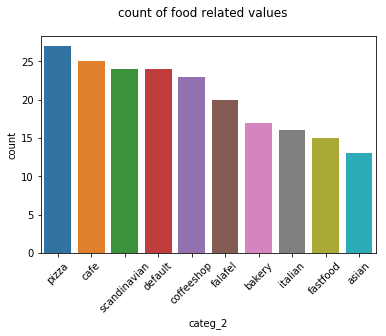

In [83]:
create_bar_plot("food","count of food related values")

In [84]:
from folium import plugins
from folium.plugins import HeatMap


The table below shows the total number of venues by borough

In [85]:
categ_name="food"

temp_=details_venues_df[["lat","lng"]][details_venues_df["categ_1"]==categ_name].groupby(details_venues_df["borough"][details_venues_df["categ_1"]==categ_name]).apply(lambda x: x.head(1))

temp_df=details_venues_nodup["categ_1"][details_venues_nodup["categ_1"]==categ_name].groupby(details_venues_nodup["borough"][details_venues_nodup["categ_1"]==categ_name]).count().to_frame("count")
temp_["count"]=temp_df["count"].values
temp_["count"]=temp_["count"].astype(int)

temp_.sort_values("count",ascending=False).head(5)

,,lat,lng,count
borough,,,,
Centrum,0,55.598697,12.997290,162
Södra Innerstaden,1,55.590019,13.008885,53
Västra Innerstaden,0,55.593719,12.983709,45
Hyllie,5,55.579654,12.996462,22
Fosie,4,55.573057,13.020688,16


Below you can see a heapmap that shows in Malmö the boroughs that have more food venues

In [86]:
lat_malmo=55.5956427
long_malmo=12.9999775

malmo_heatmat = folium.Map(location=[lat_malmo, long_malmo], zoom_start=13)



#details_venues_df.columns
heat_data = [[row['lat'], 
              row['lng'],row["count"]] for index, row in temp_.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        min_opacity=0.5,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=20,
        gradient=None,
        overlay=True).add_to(malmo_heatmat)

# Display the map
malmo_heatmat


In [88]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="shops"].unique()) #50 different types of shop venues

50

top 10 most popular shop venues:

In [89]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="shops"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="shops"]).count().sort_values(ascending=False).head(10)

categ_2
foodgrocery         50
sportsoutdoors      14
default             12
furniture           12
apparel             10
technology           9
pharmacy             7
departmentstore      6
foodliquor           6
conveniencestore     6
Name: categ_2, dtype: int64

"foodgrocery" are supermarkets and "default" seems to be like a "others" category that doesn't fit into the existing ones

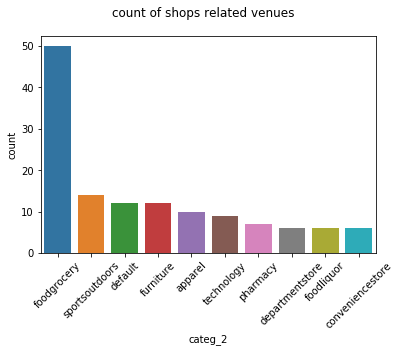

In [90]:
create_bar_plot("shops","count of shops related venues")

In [91]:
details_venues_nodup["name"][(details_venues_nodup["categ_1"]=="shops") &( details_venues_nodup["categ_2"]=="foodgrocery")].head(10)

1              Alm Livs
58        Asien Trading
14    Astrid och Aporna
1     Axfood Snabbgross
0      City Gross Malmö
10          Coop Konsum
3                  Coop
0                  Coop
1                  Coop
0                  Coop
Name: name, dtype: object

In [92]:
details_venues_nodup["name"][(details_venues_nodup["categ_1"]=="shops") &( details_venues_nodup["categ_2"]=="default")].head(10)

13                          Beyond Retro
3                              Copy Fors
5         Drewex Ram & Konstnärsmaterial
6                          Emmaus Björkå
0                           Erikshjälpen
1                          FedEx Station
9                     Humana Second Hand
39                        Naturkompaniet
5                              Skivesset
3     Sopstationen Återvinningsvaruhuset
Name: name, dtype: object

In [93]:
categ_name="shops"

temp_=details_venues_df[["lat","lng"]][details_venues_df["categ_1"]==categ_name].groupby(details_venues_df["borough"][details_venues_df["categ_1"]==categ_name]).apply(lambda x: x.head(1))

temp_df=details_venues_nodup["categ_1"][details_venues_nodup["categ_1"]==categ_name].groupby(details_venues_nodup["borough"][details_venues_nodup["categ_1"]==categ_name]).count().to_frame("count")
temp_["count"]=temp_df["count"].values
temp_["count"]=temp_["count"].astype(int)

temp_.sort_values("count",ascending=False).head(5)

,,lat,lng,count
borough,,,,
Centrum,1,55.599086,13.000199,50
Hyllie,0,55.578703,12.978891,43
Fosie,0,55.576723,13.025019,24
Limhamn-Bunkeflo,1,55.578230,12.929496,21
Södra Innerstaden,0,55.590442,13.005913,18


In [94]:
lat_malmo=55.5956427
long_malmo=12.9999775

malmo_heatmat = folium.Map(location=[lat_malmo, long_malmo], zoom_start=13)

categ_name="shops"

temp_=details_venues_df[["lat","lng"]][details_venues_df["categ_1"]==categ_name].groupby(details_venues_df["borough"][details_venues_df["categ_1"]==categ_name]).apply(lambda x: x.head(1))

temp_df=details_venues_nodup["categ_1"][details_venues_nodup["categ_1"]==categ_name].groupby(details_venues_nodup["borough"][details_venues_nodup["categ_1"]==categ_name]).count().to_frame("count")
temp_["count"]=temp_df["count"].values
temp_["count"]=temp_["count"].astype(int)

#details_venues_df.columns
heat_data = [[row['lat'], 
              row['lng'],row["count"]] for index, row in temp_.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        min_opacity=0.5,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=20,
        gradient=None,
        overlay=True).add_to(malmo_heatmat)

# Display the map
malmo_heatmat


In [96]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="parks_outdoors"].unique()) #24 different types of parks_outdoors venues

24

top 10 most popular parks_outdoors venues:

In [97]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="parks_outdoors"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="parks_outdoors"]).count().sort_values(ascending=False).head(10)

categ_2
playground      29
park            25
plaza           21
pool             6
golfcourse       6
harbor           4
sculpture        3
neighborhood     3
garden           3
beach            3
Name: categ_2, dtype: int64

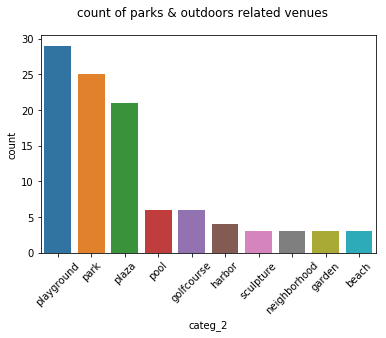

In [98]:
create_bar_plot("parks_outdoors","count of parks & outdoors related venues")

so in this category you'll find mostly playgrounds which are something that a family with small children will appreciate

In [99]:
categ_name="parks_outdoors"

temp_=details_venues_df[["lat","lng"]][details_venues_df["categ_1"]==categ_name].groupby(details_venues_df["borough"][details_venues_df["categ_1"]==categ_name]).apply(lambda x: x.head(1))

temp_df=details_venues_nodup["categ_1"][details_venues_nodup["categ_1"]==categ_name].groupby(details_venues_nodup["borough"][details_venues_nodup["categ_1"]==categ_name]).count().to_frame("count")
temp_["count"]=temp_df["count"].values
temp_["count"]=temp_["count"].astype(int)

temp_.sort_values("count",ascending=False).head(5)

,,lat,lng,count
borough,,,,
Centrum,22,55.600679,12.998381,31
Västra Innerstaden,1,55.594715,12.976664,21
Limhamn-Bunkeflo,4,55.576244,12.930664,17
Oxie,0,55.524588,13.044890,12
Södra Innerstaden,7,55.591684,13.007655,10


In [101]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="travel"].unique()) #8 different types of travel venues

8

top  most popular travel venues:

In [102]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="travel"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="travel"]).count().sort_values(ascending=False).head(10)

categ_2
busstation      50
hotel           14
trainstation     5
hostel           3
hotelbar         2
default          2
boat             2
movingtarget     1
Name: categ_2, dtype: int64

so in travel the most popular item is "bus station", and it has a low number I suspect many bus stations have not been added to the venue list.There are several ways to deal with this:
- remove the busstation value from the df since it is incomplete
- make no inference based on the "travel" category as it is incomplete and therefore unreliable

I will go for the 2nd option

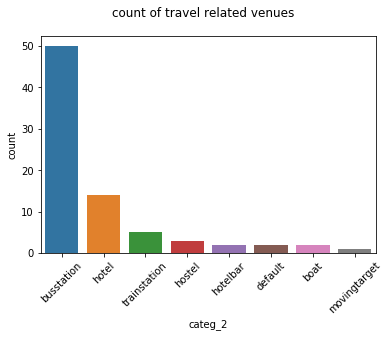

In [111]:
create_bar_plot("travel","count of travel related venues")

In [112]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="arts_entertainment"].unique()) #22 different types of arts_entertainment venues

22

top 10 most popular arts_entertainment venues:

In [113]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="arts_entertainment"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="arts_entertainment"]).count().sort_values(ascending=False).head(10)

categ_2
stadiumsoccer                16
stadium                       8
musicvenue                    6
movietheater                  4
stadiumtennis                 4
stadiumhockey                 3
performingartstheater         3
performingartsdancestudio     3
museumhistory                 3
museumart                     3
Name: categ_2, dtype: int64

we can also check which boroughs have the highest count:

In [114]:
categ_name="arts_entertainment"

temp_=details_venues_df[["lat","lng"]][details_venues_df["categ_1"]==categ_name].groupby(details_venues_df["borough"][details_venues_df["categ_1"]==categ_name]).apply(lambda x: x.head(1))

temp_df=details_venues_nodup["categ_1"][details_venues_nodup["categ_1"]==categ_name].groupby(details_venues_nodup["borough"][details_venues_nodup["categ_1"]==categ_name]).count().to_frame("count")
temp_["count"]=temp_df["count"].values
temp_["count"]=temp_["count"].astype(int)

temp_.sort_values("count",ascending=False).head(5)

,,lat,lng,count
borough,,,,
Centrum,12,55.599143,13.001106,23
Hyllie,1,55.583859,12.989994,11
Västra Innerstaden,2,55.596071,12.995151,9
Södra Innerstaden,3,55.591658,13.027954,6
Limhamn-Bunkeflo,3,55.576010,12.935554,5


In [115]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="building"].unique()) #5 different types of arts_entertainment venues

5

in categ_2 "buildings" we have mostly gyms. This shows again that the foursquare data is not complete since in Malmö there are more than 23 gyms and more than one church.

In [116]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="building"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="building"]).count().sort_values(ascending=False).head(10)

categ_2
gym                     35
religiouschurch          1
medicaldoctorsoffice     1
medical                  1
default                  1
Name: categ_2, dtype: int64

In [119]:
len(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="nightlife"].unique()) #6 different types of arts_entertainment venues

6

these are mostly pubs and sportsbars

In [120]:
details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="nightlife"].groupby(details_venues_nodup["categ_2"][details_venues_nodup["categ_1"]=="nightlife"]).count().sort_values(ascending=False).head(10)

categ_2
pub           12
cocktails      3
sportsbar      1
nightclub      1
divebar        1
beergarden     1
Name: categ_2, dtype: int64

Lets see the __most popular neighboorhoods__ by total number of venues:

In [121]:
details_venues_nodup["neigh_name"].value_counts().head(10)

Gamla staden, Malmö    59
Rådmansvången          51
Lugnet, Malmö          43
Hyllievång             35
Malmöhus               34
Västra hamnen          27
Slussen, Malmö         26
Möllevången            25
Davidshall             19
Svågertorp             19
Name: neigh_name, dtype: int64

Lets see the __most popular boroughs__ by total number of venues:

In [122]:
details_venues_nodup["borough"].value_counts().head(10)

Centrum               309
Västra Innerstaden    105
Hyllie                 97
Södra Innerstaden      96
Limhamn-Bunkeflo       68
Fosie                  66
Kirseberg              43
Rosengård              33
Husie                  32
Oxie                   19
Name: borough, dtype: int64

### 4.2 Lets look at the relationship between percentage of venues and price per square meter

In [123]:
#lets create a plot method
def create_plot_lin_reg(name_feat,df):
    fig, ax = plt.subplots(figsize=(10, 10))
    #ax.scatter(food_bor_df["percentage"],np.log(food_bor_df["12_mon_sek/sqm"]))
    
    df["log_12_mon_sek/sqm"]=apartment_prices["log_12_mon_sek/sqm"]
    sns.scatterplot(x="percentage_"+name_feat,y="log_12_mon_sek/sqm",data=df,ax=ax)
    #plt.show()
    
    #lin=0
    textstr=""
    for lin in range(len(food_bor_df)):
        textstr+=str(lin)+"-"+df.index[lin]+"\n"
        ax.annotate(str(lin), (df["percentage_"+name_feat].iloc[lin], df["log_12_mon_sek/sqm"].iloc[lin]))
    
    #https://matplotlib.org/3.1.1/gallery/recipes/placing_text_boxes.html
    # place a text box in upper left in axes coords
    props = dict( facecolor='wheat', alpha=0.5)
    ax.text(0.67, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)
    
    
    z = np.polyfit(df["percentage_"+name_feat], df["log_12_mon_sek/sqm"], 1)
    
    p = np.poly1d(z)
    
    ax.plot(np.linspace(0,0.6,100),p(np.linspace(0,0.6,100)),label="lin_reg",color="red")
    ax.legend()
    ax.set_title("Percentage of {} related venues vs log of price per square meters in SEK".format(name_feat ))



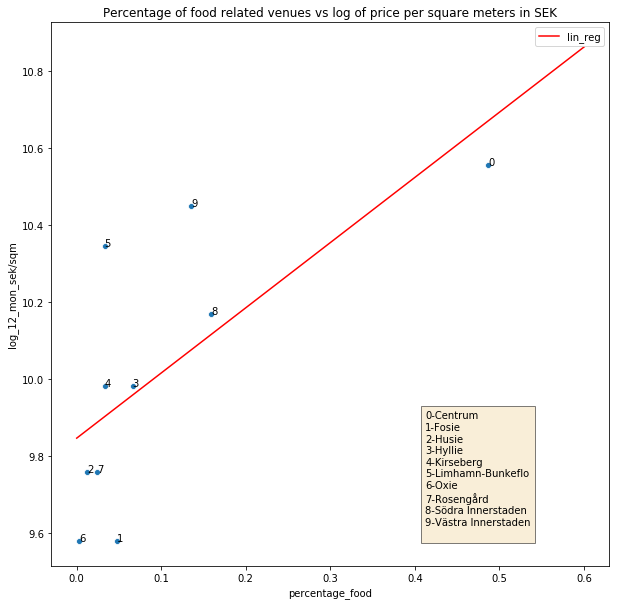

In [124]:
create_plot_lin_reg("food",food_bor_df) 

from the figure above if can be seen that 9 "Västra innestraden" is above the regression line, meaning that given the percentage of food places, in relation to the total for malmö, the price for square meter is above the average and therefore expensive.
The "Centrum" with label 0 for example even though if has a high percentage of food places with regards to the total food places in Malmö, the price per square meter is below the linear regression line, thus making it relatively cheap.

A single person that likes to go out to eat would find the "Centrum" good value for money

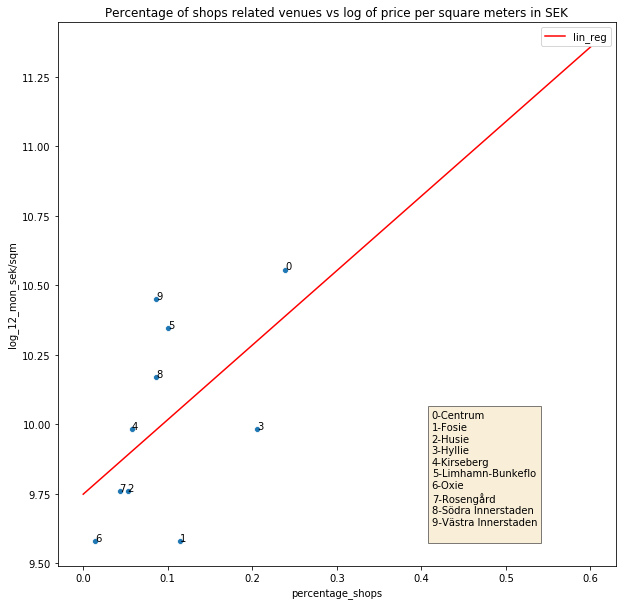

In [125]:
create_plot_lin_reg("shops",shops_bor_df) 

the picture above shows that "Hyllie" with label 3 has a relatively cheap square meter price versus the number of shops avaliable in the borough. So for families it could be a good area to live as it will be convinient to go around shopping 

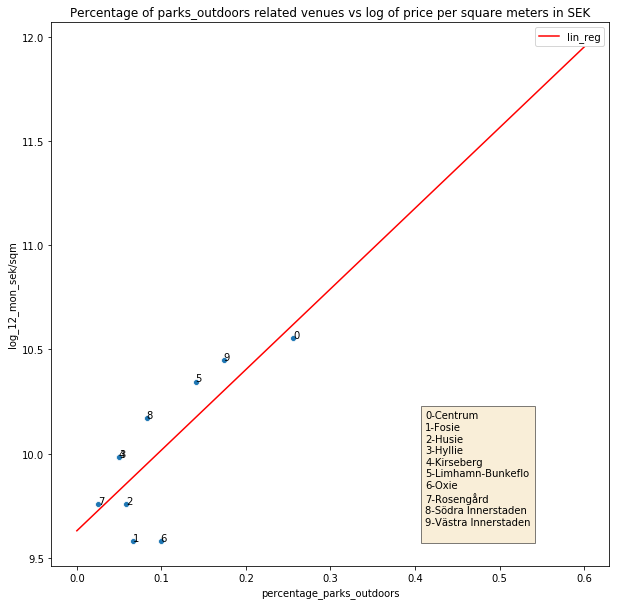

In [126]:
create_plot_lin_reg("parks_outdoors",parks_bor_df) 

The picture above shows for example that "Centrum" with label 0,  a high number of parks and playgrounds for children and the price for square meter is relatively cheap as it is below the linear regression line, So for families with small children this area could be a good choice according to this criteria


### 4.3 Clustering neighboorhoods by venue similary

In a similar fashion to what was shown in the course in week 3, we will group neighborhoods by venues to find to ones that are most similar by venues

In [127]:
# one hot encoding
malmo_onehot = pd.get_dummies(details_venues_nodup[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
malmo_onehot['Neighborhood'] = details_venues_nodup['neigh_name'] 

# move neighborhood column to the first column
fixed_columns = [malmo_onehot.columns[-1]] + list(malmo_onehot.columns[:-1])
malmo_onehot = malmo_onehot[fixed_columns]

malmo_onehot.head()

,Yoga Studio,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Beach,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Doner Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farm,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Laundry Service,Lighthouse,Lingerie Store,Liquor Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,Nightclub,Office,Opera House,Other Great Outdoors,Outdoor Supply Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,Soup Place,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Wine Bar
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kroksbäcksparken,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Möllevången,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ärtholmen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [128]:
malmo_grouped = malmo_onehot.groupby('Neighborhood').mean().reset_index()
malmo_grouped

,Neighborhood,Yoga Studio,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Beach,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Doner Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farm,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Laundry Service,Lighthouse,Lingerie Store,Liquor Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nightclub,Office,Opera House,Other Great Outdoors,Outdoor Supply Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,Soup Place,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Wine Bar
0,"Almgården, Malmö",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [129]:
malmo_grouped.shape

(128, 194)

Let's print each neighborhood along with the top 5 most common venues

In [130]:
num_top_venues = 5

for hood in malmo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = malmo_grouped[malmo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Almgården, Malmö----
                        venue  freq
0                    Bus Stop   1.0
1                 Yoga Studio   0.0
2          Mexican Restaurant   0.0
3          Miscellaneous Shop   0.0
4  Modern European Restaurant   0.0


----Almhög----
                  venue  freq
0              Bus Stop   0.2
1           Pizza Place   0.2
2  Gym / Fitness Center   0.2
3               Stadium   0.2
4         Grocery Store   0.2


----Almvik, Malmö----
                       venue  freq
0              Grocery Store   1.0
1                Yoga Studio   0.0
2                Opera House   0.0
3  Middle Eastern Restaurant   0.0
4         Miscellaneous Shop   0.0


----Annelund, Malmö----
              venue  freq
0              Park  0.25
1          Bus Stop  0.12
2       Pizza Place  0.12
3     Train Station  0.12
4  Doner Restaurant  0.12


----Annetorp----
                  venue  freq
0           Bus Station  0.29
1  Gym / Fitness Center  0.29
2          Soccer Field  0.14
3      

4     Yoga Studio  0.00


----Kristineberg, Malmö----
                       venue  freq
0                Golf Course   1.0
1                Yoga Studio   0.0
2   Mediterranean Restaurant   0.0
3  Middle Eastern Restaurant   0.0
4         Miscellaneous Shop   0.0


----Kroksbäck----
                        venue  freq
0                    Bus Stop   0.5
1                 Coffee Shop   0.5
2                 Yoga Studio   0.0
3        Other Great Outdoors   0.0
4  Modern European Restaurant   0.0


----Kroksbäcksparken----
                       venue  freq
0                       Pool  0.33
1                   Fountain  0.33
2               Soccer Field  0.33
3                     Office  0.00
4  Middle Eastern Restaurant  0.00


----Kronborg, Malmö----
                  venue  freq
0    Chinese Restaurant   0.2
1            Playground   0.2
2    Athletics & Sports   0.2
3  Gym / Fitness Center   0.2
4         Grocery Store   0.2


----Kronprinsen----
                        venue  freq

----Toarp, Malmö----
                       venue  freq
0                Music Venue   0.5
1                       Farm   0.5
2                Yoga Studio   0.0
3                 Print Shop   0.0
4  Middle Eastern Restaurant   0.0


----Toftanäs----
                  venue  freq
0  Gym / Fitness Center  0.25
1            Playground  0.12
2           Flower Shop  0.12
3        Discount Store  0.12
4             Pet Store  0.12


----Tygelsjö----
           venue  freq
0    Candy Store  0.33
1  Grocery Store  0.33
2     Food Truck  0.33
3    Yoga Studio  0.00
4         Office  0.00


----Törnrosen----
           venue  freq
0       Bus Stop  0.25
1         Market  0.25
2  Train Station  0.25
3            Gym  0.25
4    Yoga Studio  0.00


----Universitetssjukhuset MAS----
                     venue  freq
0        Indian Restaurant   0.1
1                 Gym Pool   0.1
2         Sushi Restaurant   0.1
3  Scandinavian Restaurant   0.1
4               Food Court   0.1


----Valdemarsro----

Let's put that into a pandas dataframe

In [131]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = malmo_grouped['Neighborhood']

for ind in np.arange(malmo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(malmo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Almgården, Malmö",Bus Stop,Wine Bar,Currency Exchange,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
1,Almhög,Pizza Place,Gym / Fitness Center,Grocery Store,Bus Stop,Stadium,Wine Bar,Eastern European Restaurant,Fish Market,Field,Fast Food Restaurant
2,"Almvik, Malmö",Grocery Store,Wine Bar,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop
3,"Annelund, Malmö",Park,Pizza Place,Train Station,Grocery Store,Climbing Gym,Bus Stop,Doner Restaurant,Wine Bar,Eastern European Restaurant,Fish Market
4,Annetorp,Gym / Fitness Center,Bus Station,Soccer Field,Skating Rink,Supermarket,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant


#### Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters

In [132]:
# set number of clusters
kclusters = 5

malmo_grouped_clustering = malmo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(malmo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 3, 3, 2, 3, 2, 0, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [133]:
neigh_df["Neighborhood"]=neigh_df["neigh_name"]

In [134]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

malmo_merged = neigh_df

# merge malmo_grouped with malmo_data to add latitude/longitude for each neighborhood
malmo_merged = malmo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

malmo_merged.head() # check the last columns!

,neigh_name,neigh_link,borough,address,geopy_address,geopy_lat,geopy_long,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Davidshall,https://en.wikipedia.org/wiki/Davidshall,Centrum,"Davidshall ,Malmö","Davidshall ,Malmö",55.598823,12.998539,Davidshall,3.0,Coffee Shop,Scandinavian Restaurant,Theater,Café,Bike Shop,Movie Theater,Hot Dog Joint,Pub,Thai Restaurant,Sushi Restaurant
1,Ellstorp,https://en.wikipedia.org/wiki/Ellstorp,Centrum,"Ellstorp ,Malmö","Ellstorp ,Malmö",55.604265,13.032631,Ellstorp,3.0,Water Park,Currency Exchange,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
2,"Frihamnen, Malmö","https://en.wikipedia.org/wiki/Frihamnen,_Malm%...",Centrum,"Frihamnen, Malmö","Frihamnen, Malmö",55.615554,13.010210,"Frihamnen, Malmö",3.0,Scandinavian Restaurant,Antique Shop,Harbor / Marina,Wine Bar,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
3,"Gamla staden, Malmö","https://en.wikipedia.org/wiki/Gamla_staden,_Ma...",Centrum,"Gamla staden, Malmö","Gamla staden, Malmö",55.604449,13.002700,"Gamla staden, Malmö",3.0,Hotel,Wine Bar,Coffee Shop,Scandinavian Restaurant,Pizza Place,Plaza,Furniture / Home Store,Café,Pub,Bakery
4,Inre hamnen,https://en.wikipedia.org/wiki/Inre_hamnen,Centrum,"Inre hamnen ,Malmö","Inre hamnen ,Malmö",55.612736,13.010973,Inre hamnen,3.0,Thrift / Vintage Store,Wine Bar,Doner Restaurant,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant


In [135]:
malmo_merged=malmo_merged[~malmo_merged["Cluster Labels"].isnull()] #since we have some neighboorhoods with no venues there are some nans in the clusters

In [136]:
malmo_merged["Cluster Labels"]=malmo_merged["Cluster Labels"].astype(int)

Finally, let's visualize the resulting clusters

In [137]:
# create map
lat_malmo=55.5956427
long_malmo=12.9999775

map_clusters = folium.Map(location=[lat_malmo, long_malmo], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(malmo_merged['geopy_lat'], malmo_merged['geopy_long'], malmo_merged['Neighborhood'], malmo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can check also which neighboorhoods are in each cluster:

In [139]:
temp_df=malmo_merged["Neighborhood"].groupby(malmo_merged["Cluster Labels"]).count().to_frame("count")
temp_df["Neighborhood"]=malmo_merged["Neighborhood"].groupby(malmo_merged["Cluster Labels"]).apply(lambda x: x.unique())

temp_df

,count,Neighborhood
Cluster Labels,,
0,17,"[Katrinelund, Almhög, Almvik, Malmö, Västra Sö..."
1,6,"[Kastanjegården, Djupadal, Rosenvång, Riseberg..."
2,17,"[Värnhem, Fosieby, Gullviksborg, Hindby, Östra..."
3,84,"[Davidshall, Ellstorp, Frihamnen, Malmö, Gamla..."
4,4,"[Lönngården, Holma, Malmö, Rosengård Centrum, ..."


As per above cluster 3 contains the most neighboorhoods, 1 and 4 the least

In [140]:
temp_df=malmo_merged["borough"].groupby(malmo_merged["Cluster Labels"]).count().to_frame("count")
temp_df["borough"]=malmo_merged["borough"].groupby(malmo_merged["Cluster Labels"]).apply(lambda x: x.unique())
temp_df["num_borough"]=temp_df["borough"].apply(lambda x: len(x))
temp_df

,count,borough,num_borough
Cluster Labels,,,
0,17,"[Centrum, Fosie, Limhamn-Bunkeflo, Södra Inner...",8
1,6,"[Fosie, Limhamn-Bunkeflo, Husie, Oxie]",4
2,17,"[Centrum, Fosie, Limhamn-Bunkeflo, Västra Inne...",8
3,84,"[Centrum, Fosie, Limhamn-Bunkeflo, Södra Inner...",10
4,4,"[Södra Innerstaden, Hyllie, Rosengård]",3


As per above cluster 3 has the most numbers of boroughs (col "num_borough") , 0 ,1 and 4 the least

Cluster 0:

In [141]:
malmo_merged.loc[malmo_merged['Cluster Labels'] == 0, malmo_merged.columns[ list(range(7, malmo_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Katrinelund,0,Martial Arts Dojo,Gym / Fitness Center,Wine Bar,Eastern European Restaurant,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm
20,Almhög,0,Pizza Place,Gym / Fitness Center,Grocery Store,Bus Stop,Stadium,Wine Bar,Eastern European Restaurant,Fish Market,Field,Fast Food Restaurant
21,"Almvik, Malmö",0,Grocery Store,Wine Bar,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop
35,Västra Söderkulla,0,Print Shop,Grocery Store,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop
39,Bunkeflostrand,0,Soccer Field,Gym / Fitness Center,Pub,Grocery Store,Bus Station,Stadium,Doner Restaurant,Fish Market,Field,Fast Food Restaurant
42,Gamla Limhamn,0,Grocery Store,Liquor Store,Pharmacy,Coffee Shop,Sporting Goods Shop,Fast Food Restaurant,Automotive Shop,Bakery,Eastern European Restaurant,Flea Market
52,Tygelsjö,0,Candy Store,Food Truck,Grocery Store,Wine Bar,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
58,"Flensburg, Malmö",0,Coffee Shop,Fast Food Restaurant,Currency Exchange,Bus Stop,Grocery Store,Eastern European Restaurant,Flea Market,Fish Market,Field,Farm
62,Sofielunds industriområde,0,Brewery,Playground,Grocery Store,Falafel Restaurant,Music Venue,Wine Bar,Eastern European Restaurant,Fish Market,Field,Fast Food Restaurant
71,"Kronborg, Malmö",0,Chinese Restaurant,Playground,Gym / Fitness Center,Athletics & Sports,Grocery Store,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant


as per above cluster 0 seems to be broad by venue types

Cluster 1:

In [142]:
malmo_merged.loc[malmo_merged['Cluster Labels'] == 1, malmo_merged.columns[ list(range(7, malmo_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Kastanjegården,1,Playground,Gym / Fitness Center,Wine Bar,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
40,Djupadal,1,Playground,Park,Camera Store,Flower Shop,Wine Bar,Eastern European Restaurant,Fish Market,Field,Fast Food Restaurant,Farm
49,Rosenvång,1,Playground,Café,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
112,"Riseberga, Malmö",1,Playground,Wine Bar,Eastern European Restaurant,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
116,Videdal,1,Playground,Wine Bar,Eastern European Restaurant,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
131,Käglinge,1,Playground,Flower Shop,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant


cluster 1 seems to offer playgrounds so could be good boroughs for families with small children

Cluster 2:

In [143]:
malmo_merged.loc[malmo_merged['Cluster Labels'] == 2, malmo_merged.columns[ list(range(7, malmo_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Värnhem,2,Bus Stop,Hot Dog Joint,Garden,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm
24,Fosieby,2,Bus Stop,Music Venue,Wine Bar,Food,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
28,Gullviksborg,2,Bus Stop,Wine Bar,Currency Exchange,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
31,Hindby,2,Bus Stop,Fast Food Restaurant,Grocery Store,Restaurant,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Farm
36,Östra Söderkulla,2,Bus Stop,Stadium,Wine Bar,Electronics Store,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm
38,"Bellevue, Malmö",2,Bus Stop,Gym,Golf Course,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm
41,Elinelund,2,Bus Stop,Grocery Store,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
67,Dammfri,2,Bus Stop,Scandinavian Restaurant,Falafel Restaurant,Food,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Fabric Shop
86,Kroksbäck,2,Coffee Shop,Bus Stop,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
89,Lindeborg,2,Bus Stop,Grocery Store,Moving Target,Juice Bar,Wine Bar,Eastern European Restaurant,Fish Market,Field,Fast Food Restaurant,Farm


Cluster 2, seems to be focused on transportation and it covers the peripheral areas of Malmö

Cluster 3:

In [146]:
malmo_merged.loc[malmo_merged['Cluster Labels'] == 3, malmo_merged.columns[ list(range(7, malmo_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Davidshall,3,Coffee Shop,Scandinavian Restaurant,Theater,Café,Bike Shop,Movie Theater,Hot Dog Joint,Pub,Thai Restaurant,Sushi Restaurant
1,Ellstorp,3,Water Park,Currency Exchange,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
2,"Frihamnen, Malmö",3,Scandinavian Restaurant,Antique Shop,Harbor / Marina,Wine Bar,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
3,"Gamla staden, Malmö",3,Hotel,Wine Bar,Coffee Shop,Scandinavian Restaurant,Pizza Place,Plaza,Furniture / Home Store,Café,Pub,Bakery
4,Inre hamnen,3,Thrift / Vintage Store,Wine Bar,Doner Restaurant,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
6,"Lugnet, Malmö",3,Café,Indian Restaurant,Thai Restaurant,Bakery,Falafel Restaurant,Gift Shop,Coffee Shop,Scandinavian Restaurant,Burger Joint,Chinese Restaurant
7,Malmöhus,3,Restaurant,Café,Park,Burger Joint,Art Museum,History Museum,Science Museum,Italian Restaurant,Field,Seafood Restaurant
9,"Norra hamnen, Malmö",3,Boat or Ferry,Wine Bar,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
10,"Oljehamnen, Malmö",3,Harbor / Marina,Wine Bar,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop
11,Rådmansvången,3,Indian Restaurant,Coffee Shop,Falafel Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Restaurant,Thrift / Vintage Store,Pharmacy,Bakery,Juice Bar


Cluster 3 seems to be focused on food venues, maybe interesting for single people who like to eat out

Cluster 4:

In [147]:
malmo_merged.loc[malmo_merged['Cluster Labels'] == 4, malmo_merged.columns[ list(range(7, malmo_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Lönngården,4,Food & Drink Shop,Convenience Store,Hawaiian Restaurant,Doner Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant
84,"Holma, Malmö",4,Convenience Store,Currency Exchange,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop
100,Rosengård Centrum,4,Falafel Restaurant,Gas Station,Wine Bar,Food,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm,Fabric Shop
103,"Örtagården, Malmö",4,Convenience Store,Bus Stop,Falafel Restaurant,Wine Bar,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farm


cluster 4 seems to focused on peripheral areas and food related venues

## 5.Results and Discussion <a name="results"></a>

After doing our data exploration we can now advise single persons and families with children to which borouhs of malmö offer which type of venues and do so at a reasonable price:

Centrum borough seems to be good value in terms of restaurants and also playgrounds, for finding supermarkets nearby value for money can be found in Hyllie as well.
The Centrum borough seems to offer a broad variety of venues having plenty of playgrounds which is unusual for a city centrum

Discussion:

The main concern with this study is its reliance on the foursquare data, which as we discussed before seems to missing data points for example bus stations, churches, discos. 

Foursquare number of venues also changes on a daily basis so reproducibility of this study is an issue.

Most of the foursquare data is focused on restaurants and places to go out in the city centrum, probably turists to malmö make many of the updates on the site, so it is more centered on touristic relevant info.

For a more unbiases and accurate study more data sources with be needed with regards to venue details


## 6.Conclusion <a name="conclusion"></a>

So we scrapped the neighborhoods and boroughs for Malmö from Wikipedia, we got the apartment sales prices and we got the venue details from foursquare API.

While doing data cleansing and preparation and analysis it become clear that foursquare doesn't hold a complete set of data for all categories. For a more serious analysis of the venues in Malmö a much larger effort in data cleansing and data source quality would be required.

We then did some data exploration to see what are the most common values in each category and displayed these as bar charts and heatmaps

We also did an analysis between the percentage of venues in a given category versus the average square meter price, this analysis could help determine if a neighborhood offers value per money for a potential buyer. For this we used linear regression as a tool.

We looked at the perspective of value for different stakeholders: children with small families, looking for playground availability and relatively cheap price of square meters, could try the "Centrum" A single person looking to go out for food instead of cooking, could also look at "Centrum" as an area of value for money People that are interested in the convenience of having shops nearby, and have a relatively cheap price per square meter could instead look at "Hyllie"
